# T-test

We often want to compare a treatment group to a control group
to identify whether or not some response occured due to the treatment.
An easy example is to compare the bodyweights of mice
fed either a normal diet or a high fat diet.

This example is taken from [Data Analysis for Life Scientists](https://leanpub.com/dataanalysisforthelifesciences)

- Control mouse population: https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleControlsPopulation.csv
- Large group experiment: https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/mice_pheno.csv
- 12 x 12 experiment: https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleMiceWeights.csv

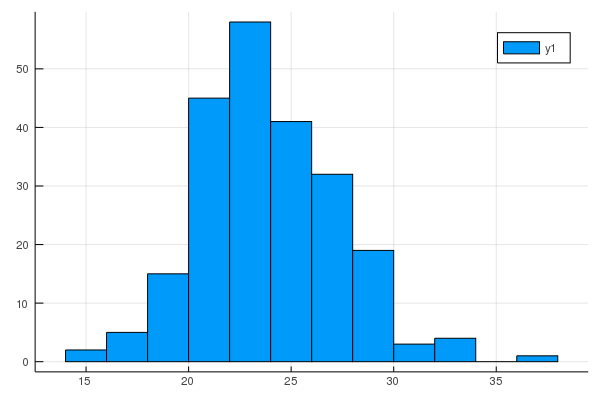

In [1]:
using CSV
using DataFrames
using Statistics
using HypothesisTests
using StatsPlots
using HTTP

controls_url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleControlsPopulation.csv"
phenotypes_url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/mice_pheno.csv"
hfd_url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleMiceWeights.csv"

controls = CSV.read(HTTP.get(controls_url).body)
phenotypes = CSV.read(HTTP.get(phenotypes_url).body)
hfd = CSV.read(HTTP.get(hfd_url).body)
# make a histogram of control mice
histogram(controls.Bodyweight)

In [2]:
describe(controls.Bodyweight)

Summary Stats:
Length:         225
Missing Count:  0
Mean:           23.893378
Minimum:        15.510000
1st Quartile:   21.510000
Median:         23.540000
3rd Quartile:   26.080000
Maximum:        36.840000
Type:           Float64


This shows what the weights of a population of normal femal mice
would look like, absent any special treatment.
Now let's look at an experiment with 24 mice,
where 12 mice were fed normal chow,
and the other 12 were given a high-fat diet.

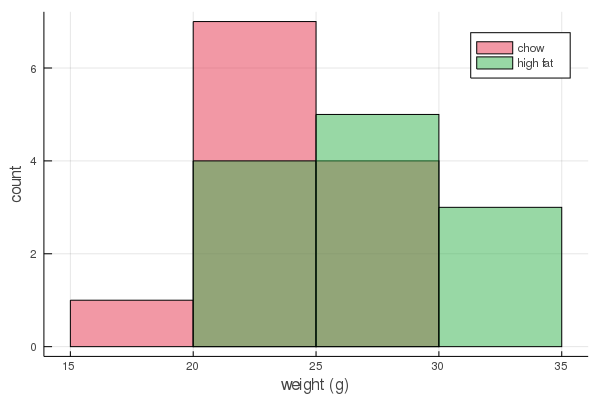

In [3]:
chow = hfd[hfd.Diet .== "chow", :Bodyweight]
hf = hfd[hfd.Diet .== "hf", :Bodyweight]
chowc = RGBA(0.9,0.2,0.3, 0.5)
hfc = RGBA(0.2,0.7,0.3, 0.5)

histogram(chow, color=chowc, label="chow",
        ylabel="count", xlabel="weight (g)")
histogram!(hf, color=hfc, label="high fat")

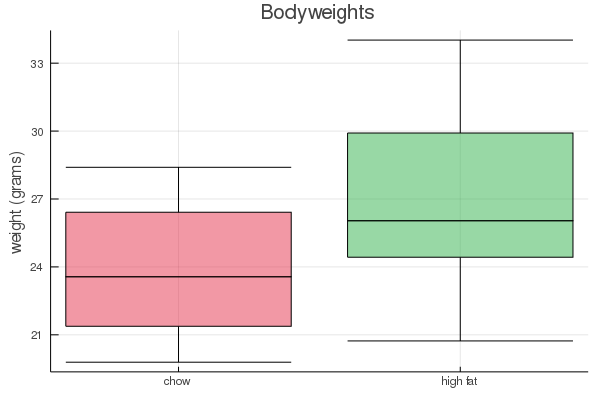

In [4]:
boxplot([chow, hf], color=[chowc hfc], title="Bodyweights", legend=false,
         ylabel="weight (grams)", xticks=([1,2], ["chow", "high fat"]))

In [5]:
@info "Chow"
describe(chow)
@info "High fat"
describe(hf)

┌ Info: Chow
└ @ Main.##377 string:1
Summary Stats:
Length:         12
Missing Count:  0
Mean:           23.813333
Minimum:        19.790000
1st Quartile:   21.377500
Median:         23.565000
3rd Quartile:   26.415000
Maximum:        28.400000
Type:           Float64
┌ Info: High fat
└ @ Main.##377 string:3
Summary Stats:
Length:         12
Missing Count:  0
Mean:           26.834167
Minimum:        20.730000
1st Quartile:   24.427500
Median:         26.040000
3rd Quartile:   29.915000
Maximum:        34.020000
Type:           Float64


The mean of the high-fat group is clearly higher
than the group fed normal chow.
The question is: is this difference meaningful?

Afterall, the weights substantilly overlap.
In addition, the heaviest mouse in the highfat diet group
is lighter than the heaviest mouse in the control population:

In [6]:
any(x -> x > maximum(hf), controls.Bodyweight)

true

... and about 25% of mice in the control population are heavier
than the median high-fat diet-fed mouse.

In [7]:
count(x-> x > quantile(hf, .5), controls.Bodyweight) / nrow(controls)

0.2577777777777778

Of course, we usually don't have this large control population to compare to,
but it's possible we just happened to get some particularly heavy mice
in our high-fat group,
or even some particularly light mice in our experimental control group.

A t-test can be used to test the null hypothesis (h₀) that the two groups
are drawn from the same population.
Since we don't know whether or not the distributions of weight
in the normal chow and high fat groups
have the same variance,
I'll use the `UnequalVarianceTTest()` function from `HypothesisTests.jl`

In [8]:
tt = UnequalVarianceTTest(hf, chow)

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          3.020833333333332
    95% confidence interval: (-0.043, 6.0846)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0530

Details:
    number of observations:   [12,12]
    t-statistic:              2.055173991656228
    degrees of freedom:       20.236006565563617
    empirical standard error: 1.4698674397387135


In [9]:
@show pvalue(tt)

pvalue(tt) = 0.05299887874532343


0.05299887874532343

What this p-value means is that, under the null hypothesis
(that there's no difference between the normal mice and the high-fat diet mice),
and given the distribution in the control mice,
we'd expect to get the distribution we actually see about 5.3% of the time.

Another way to show that is with a simulation.
Since the null hypotheses is that these mice all came from
the same random distribution of weights,
we'll get a normal distribution from the mean and standard deviation
of all mice,
randomly pull 24 samples from it a few thousand times,
then count how often the difference in means is the same or greater
than what we observed.

In [10]:
# mean and standard deviation
μ = mean(hfd.Bodyweight)
σ = std(hfd.Bodyweight)

# normal distribution with these parameters
using Distributions
D = Normal(μ, σ)

Normal{Float64}(μ=25.32375, σ=3.844476345299216)

In [11]:
# determine the difference between high fat and control mice
# in our experiment
dif = abs(mean(chow) - mean(hf))

sim_controls = rand(D, 5000, 12)
sim_hf = rand(D, 5000, 12)

control_means = mean(sim_controls, dims=2)
hf_means = mean(sim_hf, dims=2)

sim_difs = abs.(control_means .- hf_means)

# count how many of our simulation runs had an absolute difference
# at least as high as our observerd difference.
mean(x-> x >= dif, sim_difs)

0.0512

## Using Soss.jl

test

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*